![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/PDF_TO_TEXT.ipynb)

# Extract Tables from PDF

To run this yourself, you will need to upload your **Spark OCR** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

For more in-depth tutorials: https://github.com/JohnSnowLabs/spark-ocr-workshop/tree/master/jupyter

## 1. Colab Setup

Install correct version of Pillow and Restart runtime

In [1]:
# Install correct Pillow version
import PIL
if PIL.__version__  != '6.2.1':
  print ('Installing correct version of Pillow. Kernel will restart automatically')
  !pip install --upgrade pillow==6.2.1
  # hard restart runtime
  import os
  os.kill(os.getpid(), 9)
else:
  print ('Correct Pillow detected')

Correct Pillow detected


Read licence key

In [10]:
import os
import json

with open('./spark_ocr.json', 'r') as f:
    license_keys = json.load(f)

secret = license_keys['JSL_OCR_SECRET']
os.environ['JSL_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
version = ocr_secret.split('-')[0]
print ('Spark OCR Version:', version)

Spark OCR Version: 1.6.0


Install Dependencies

In [ ]:
# Install Java
!apt-get update
!apt-get install -y openjdk-8-jdk
!java -version

# Install pyspark, SparkOCR, and SparkNLP
!pip install --ignore-installed -q pyspark==2.4.4
# Insall Spark Ocr from pypi using secret
!python -m pip install --upgrade spark-ocr==$version  --extra-index-url https://pypi.johnsnowlabs.com/$secret
# or install from local path
# %pip install --user ../../python/dist/spark-ocr-[version].tar.gz

Importing Libraries

In [7]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]


Start Spark Session

In [11]:
spark = start(secret=secret)
spark

## 2. Read a sample pdf file

In [12]:

pdf_example = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/tabular-pdf/data.pdf')
pdf_example_df = spark.read.format("binaryFile").load(pdf_example).cache()

Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/pdfs/tabular-pdf/data.pdf 
        width: 2550
        height: 3299
        mode: 10


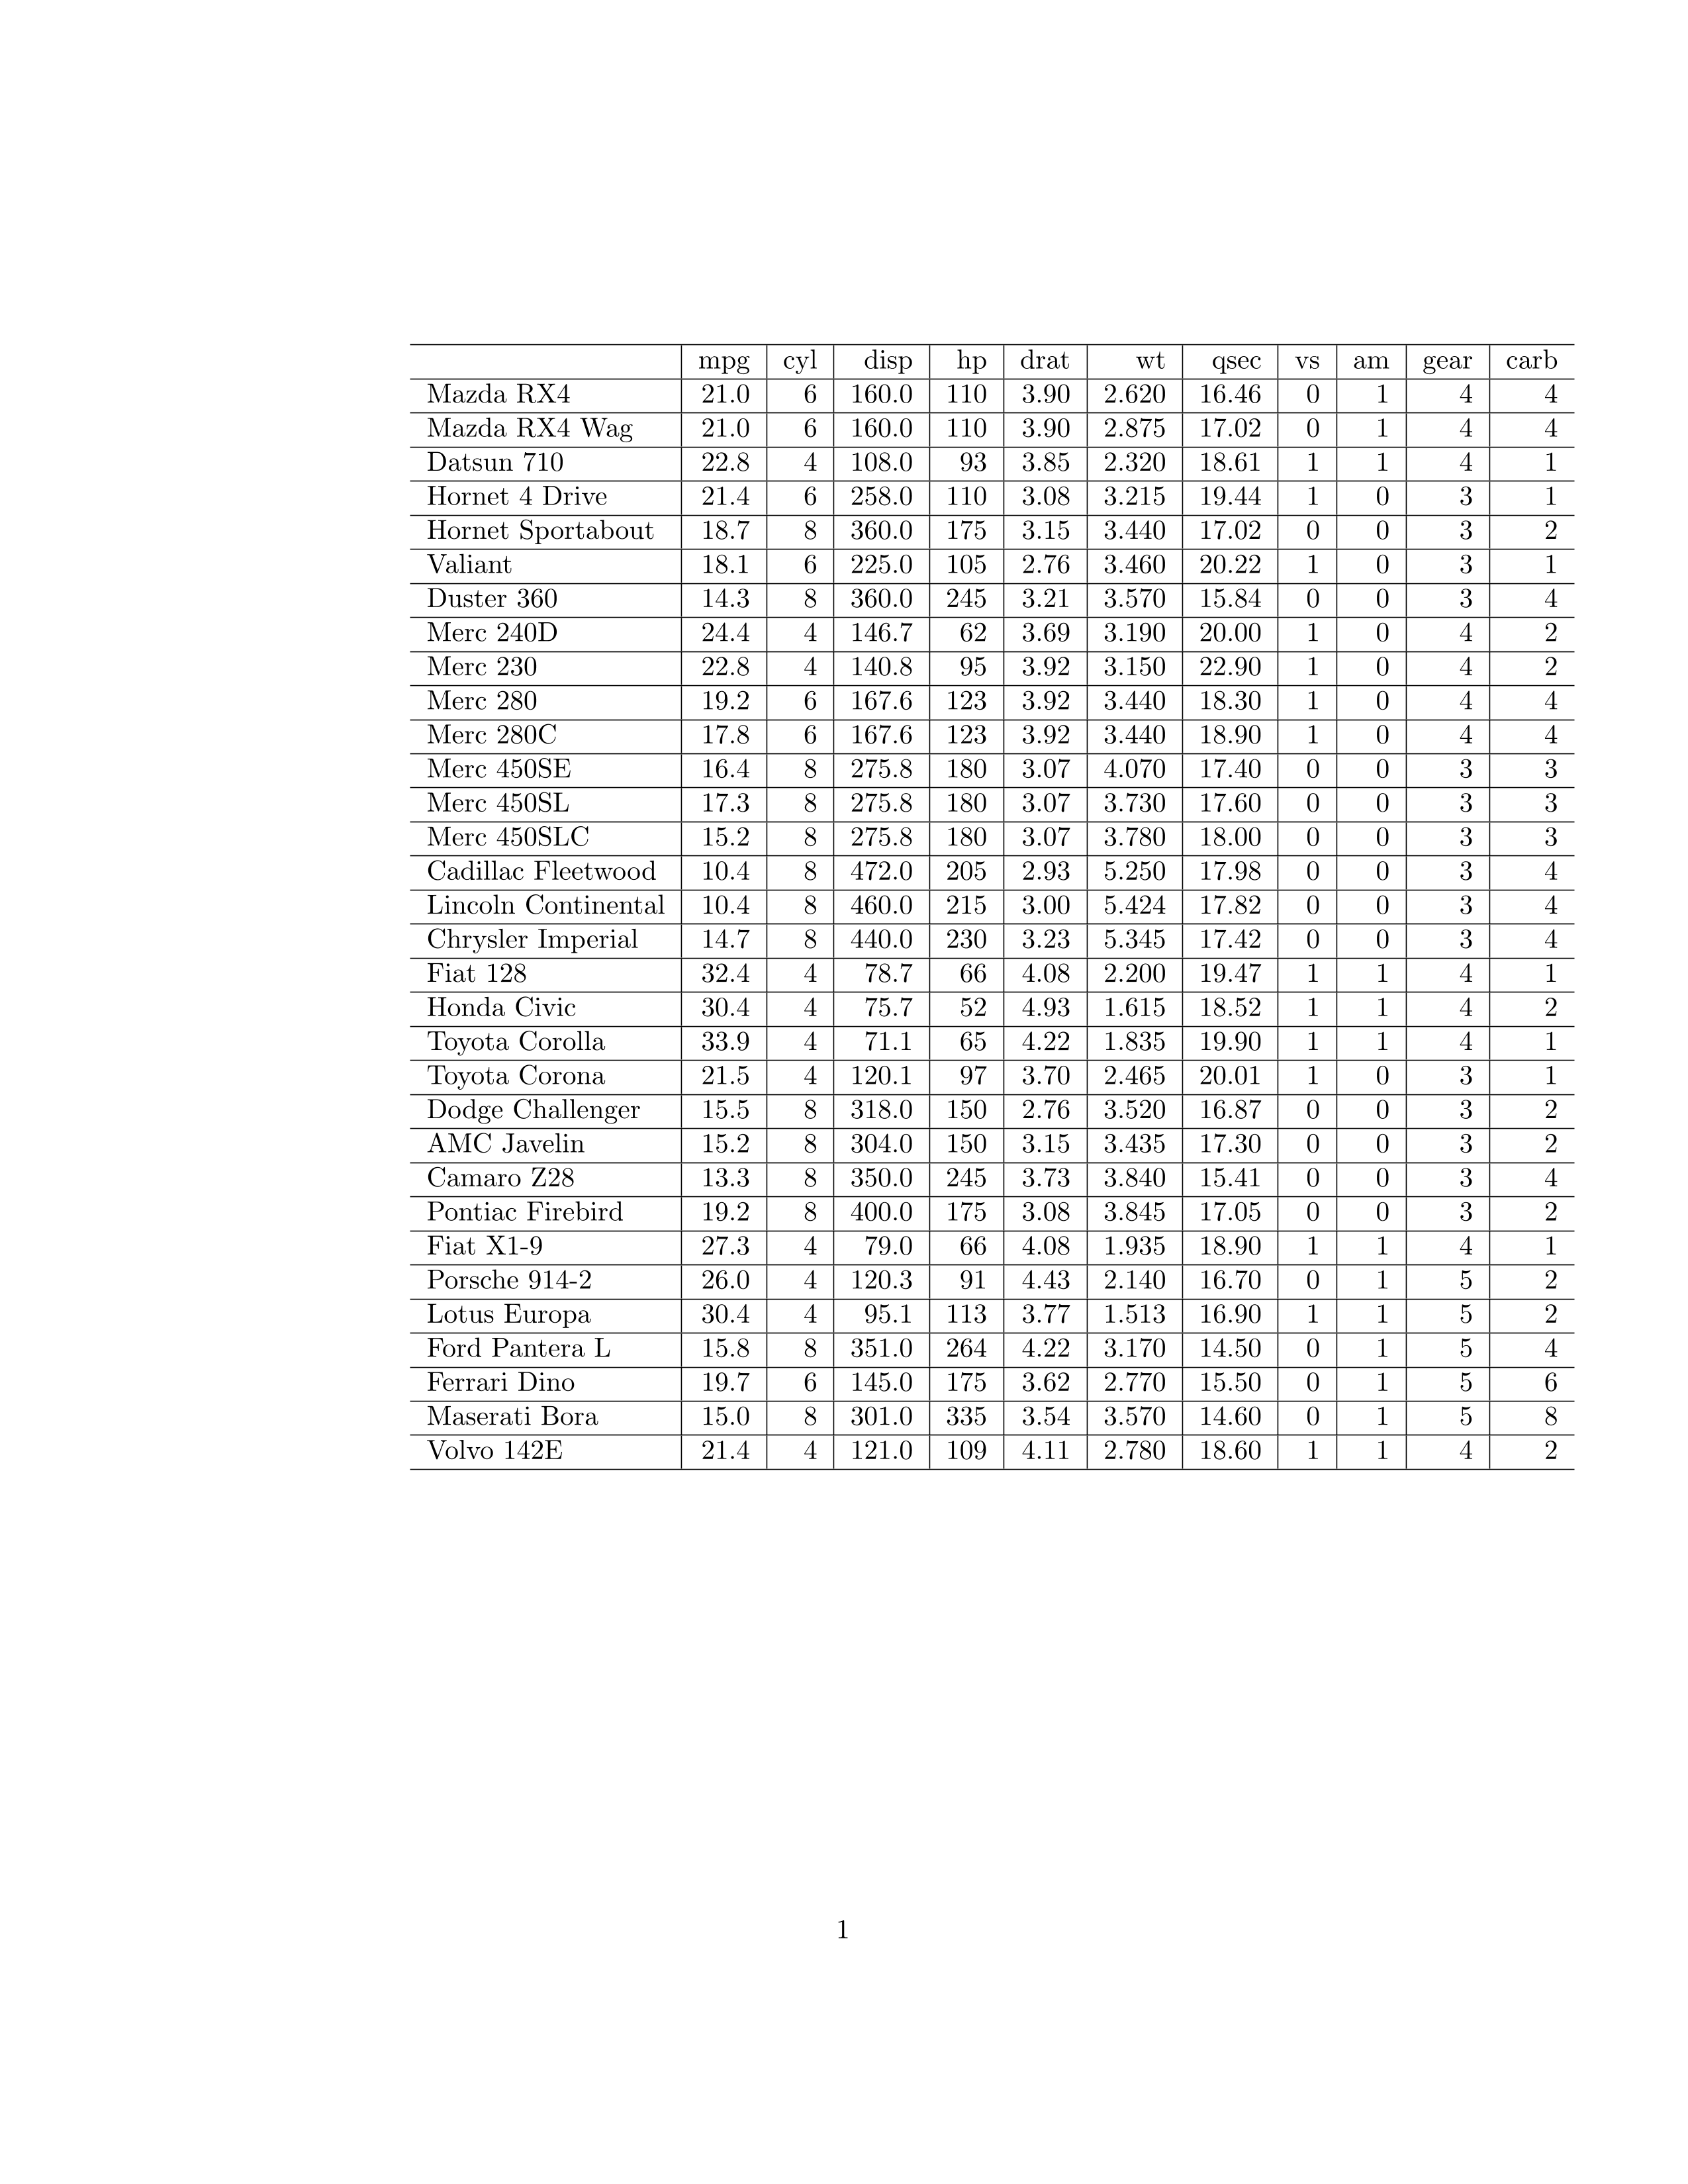

In [13]:
image_df = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .transform(pdf_example_df.select("content", "path"))
for r in image_df.limit(1).collect():
    display_image(r.image)

## 3. Extract tables from PDF using a sinlge transformer

In [14]:
pdf_to_text_table = PdfToTextTable()
pdf_to_text_table.setInputCol("content")
pdf_to_text_table.setOutputCol("table")
pdf_to_text_table.setMethod("basic")
pdf_to_text_table.setGuess(True)


table = pdf_to_text_table.transform(pdf_example_df)


## 4. Post-Processing

### Raw result

In [15]:

table.select(table["table.chunks"].getItem(0)["chunkText"]).show(1, False)

+----------------------------------------------------------+
|table.chunks AS chunks#102[0].chunkText                   |
+----------------------------------------------------------+
|[, mpg, cyl, disp, hp, drat, wt, qsec, vs, am, gear, carb]|
+----------------------------------------------------------+
only showing top 1 row



### Convert to table and dataframe

In [16]:
res = table.toPandas()

In [18]:
# extract ALL tables and create dataframes
dfs = []
for docu in res['table'].values:
    rows = []
    for page in docu[1]:
        cols = []
        for row in page:
            #print (row[0])
            cols.append(str(row[0]))
        rows.append(cols)

    rows = np.asarray(rows)

    df = pd.DataFrame(rows[1:], columns=rows[0])
    dfs.append(df)

In [20]:
#first dataframe in list of dataframes
dfs[0]

,,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


In [19]:
#print all
for df in dfs:
  print (df)

                          mpg cyl   disp   hp  ...   qsec vs am gear carb
0             Mazda RX4  21.0   6  160.0  110  ...  16.46  0  1    4    4
1         Mazda RX4 Wag  21.0   6  160.0  110  ...  17.02  0  1    4    4
2            Datsun 710  22.8   4  108.0   93  ...  18.61  1  1    4    1
3        Hornet 4 Drive  21.4   6  258.0  110  ...  19.44  1  0    3    1
4     Hornet Sportabout  18.7   8  360.0  175  ...  17.02  0  0    3    2
5               Valiant  18.1   6  225.0  105  ...  20.22  1  0    3    1
6            Duster 360  14.3   8  360.0  245  ...  15.84  0  0    3    4
7             Merc 240D  24.4   4  146.7   62  ...  20.00  1  0    4    2
8              Merc 230  22.8   4  140.8   95  ...  22.90  1  0    4    2
9              Merc 280  19.2   6  167.6  123  ...  18.30  1  0    4    4
10            Merc 280C  17.8   6  167.6  123  ...  18.90  1  0    4    4
11           Merc 450SE  16.4   8  275.8  180  ...  17.40  0  0    3    3
12           Merc 450SL  17.3   8  275